In [1]:
import sys
sys.path.insert(0, '..')

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams.update({'font.size': 16})

import numpy as np

import reference_LFs as refLF
from paus_utils import *

from jpasLAEs.utils import bin_centers
from load_lya_LF import load_combined_LF

import numpy as np

In [3]:
def power_fit(Lx, A, B):
    return 10 ** (A * (np.log10(Lx) - 43.5) + B)
    
def load_mcmc_powerlaw_fit():
    flat_samples = np.load('/home/alberto/cosmos/LAEs/npy/mcmc_powerlaw_fit_chain.npy')

    Phi_fit_i = []
    for ii, step in enumerate(flat_samples[::-1]):
        if ii == 10_000:
            break
        Phi_fit_i.append(power_fit(Lx, step[0], step[1]))
    Phi_fit_84 = np.percentile(Phi_fit_i, 84, axis=0)
    Phi_fit_16 = np.percentile(Phi_fit_i, 16, axis=0)
    Phi_fit_50 = np.percentile(Phi_fit_i, 50, axis=0)
    return Phi_fit_16, Phi_fit_50, Phi_fit_84

In [4]:
# Load the QSO mock to compare
from load_paus_mocks import load_qso_mock
from jpasLAEs.utils import flux_to_mag

source_cats_dir = '/home/alberto/almacen/Source_cats'
mock_path = f'{source_cats_dir}/QSO_PAUS_LAES_2'
mock = load_qso_mock(mock_path)

mock['r_mag'] = flux_to_mag(mock['flx_0'][-4], w_central[-4])

# Load the W3 catalog Xmatch with SDSS

sdss_xm = pd.read_csv('/home/alberto/almacen/PAUS_data/catalogs/Xmatch_SDSS_W3.csv')

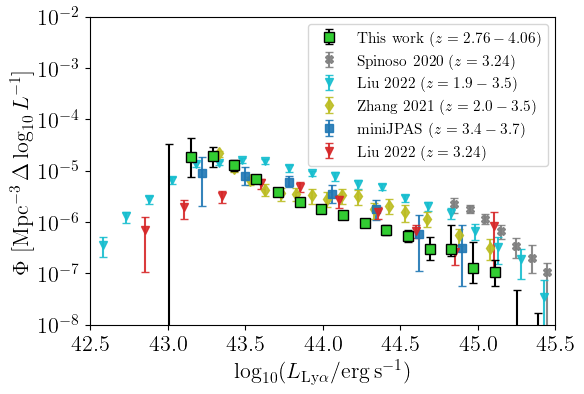

In [5]:
survey_list = ['W3']
nb_list = [[0, 2], [2, 4], [4, 6], [6, 8],
           [8, 10], [10, 12], [12, 14], [14, 16]]
# nb_list = [[0, 2]]


LyaLF = load_combined_LF(survey_list, nb_list, combined_LF=True)

# # LF of the mock
# nb1, nb2 = nb_list[0][0], nb_list[-1][-1]
# L_bins = np.linspace(40, 47, 100)
# L_bins_c = bin_centers(L_bins)
# L_bins_w = L_bins[1] - L_bins[0]
# mask_mock = ((NB_z(mock['zspec']) >= nb1)
#              & (NB_z(mock['zspec']) <= nb2)
#              & (mock['EW0_lya_spec'] > 30)
#              & (mock['r_mag'] < 24)
#              & (mock['r_mag'] > 17))
# mock_LF = np.histogram(mock['L_lya_spec'][mask_mock], L_bins)[0]\
#               / L_bins_w / Lya_effective_volume(nb1, nb2, 400)
# ax.plot(L_bins_c, mock_LF)

fig, ax = plt.subplots(figsize=(6, 4))

ax.errorbar(LyaLF['LF_bins'], LyaLF['LF_total'],
            yerr=LyaLF['LF_total_err'],
            fmt='s', ls='', mfc='limegreen', mec='k',
            ms=7, ecolor='k', capsize=3,
            label=f'This work $(z={z_NB(nb_list[0][0]):0.2f}-{z_NB(nb_list[-1][-1]):0.2f})$')

reference_LFs = [refLF.ds20_z324, refLF.l22, refLF.z21,
                 refLF.tt23_z2038, refLF.l22_z324]
for j, lf in enumerate(reference_LFs):
    ax.errorbar(lf['logL'], lf['Phi'],
                yerr=[lf['yerr_minus'], lf['yerr_plus']],
                linestyle='', fmt=lf['fmt'], c=lf['color'],
                alpha=0.9, label=lf['label'], capsize=3,
                zorder=-99)

ax.set_yscale('log')
ax.set_ylim(1e-8, 1e-2)
ax.set_xlim(42.5, 45.5)

ax.legend(fontsize=11)

ax.set_xlabel(r'$\log_{10}(L_{\mathrm{Ly}\alpha}/\mathrm{erg\,s}^{-1})$')
ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}\,\Delta\log_{10}L^{-1}$]')

ax.set_yticks(np.logspace(-8, -2, 7))

plt.show()

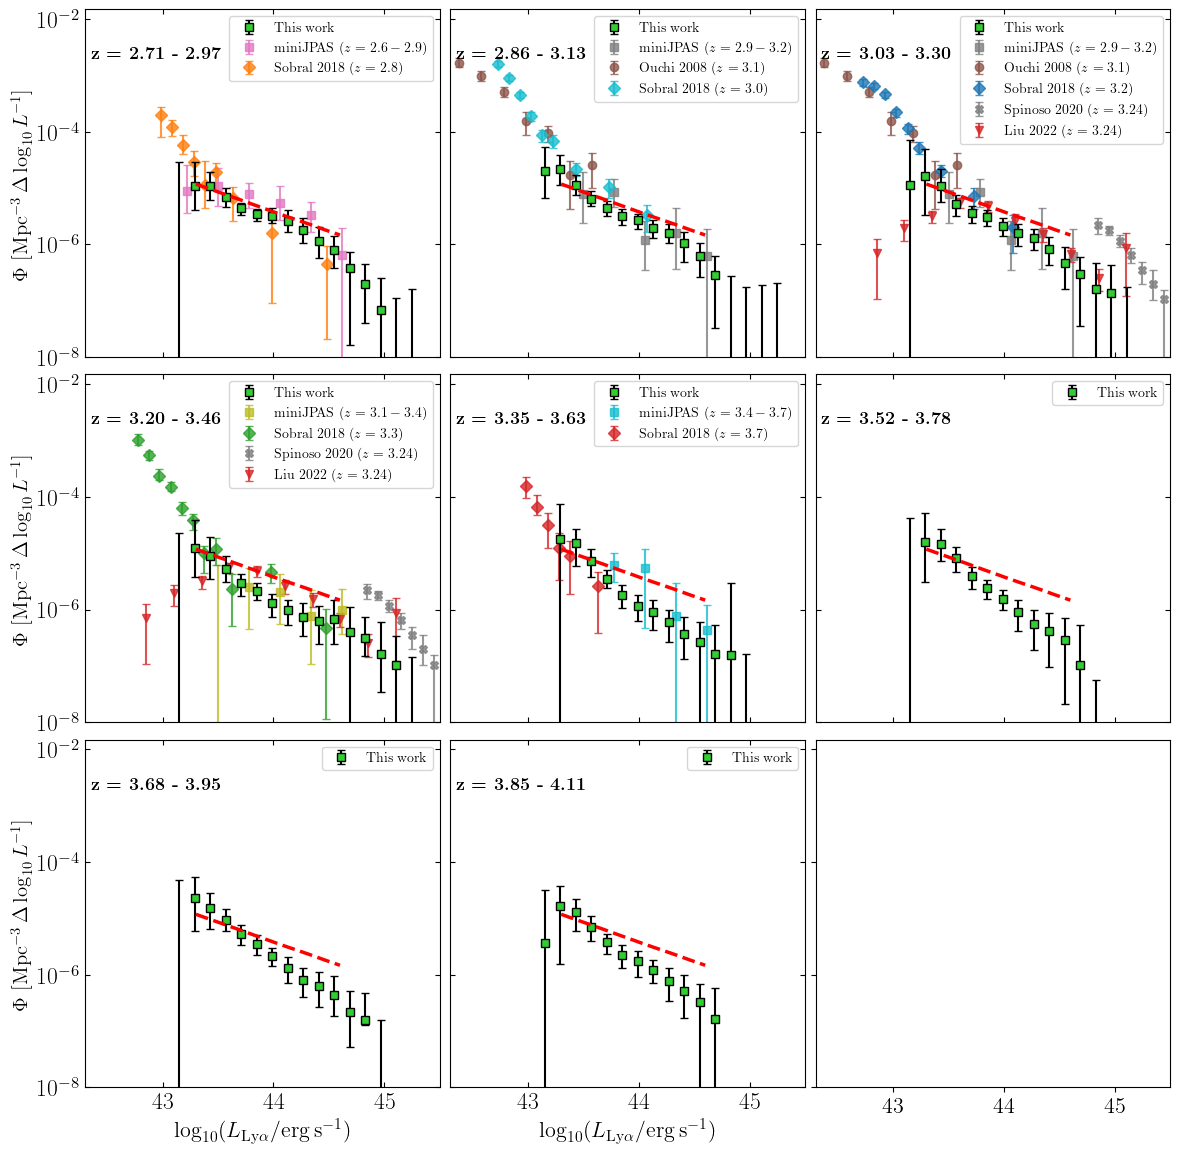

In [17]:
survey_list = ['W3']
nb_list = [[0, 2], [2, 4], [4, 6], [6, 8],
           [8, 10], [10, 12], [12, 14], [14, 16], []]

fig, axs = plt.subplots(3, 3, figsize=(14, 14), sharey=True, sharex=True,
                        width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

reference_LFs = [[refLF.tt23_z2630, refLF.s18d],
                 [refLF.tt23_z2833, refLF.u08, refLF.s18b],
                 [refLF.tt23_z2833, refLF.u08, refLF.s18c, refLF.ds20_z324,
                  refLF.l22_z324],
                 [refLF.tt23_z3135, refLF.s18e, refLF.ds20_z324, refLF.l22_z324],
                 [refLF.tt23_z3338, refLF.s18f],
                 [],
                 [],
                 []]

LFs_mult_list = []
LFs_err_mult_list = []

for iii, ax in enumerate(axs.flatten()):
    if len(nb_list[iii]) == 0:
        continue

    LyaLF = load_combined_LF(survey_list, [nb_list[iii]])
    LFs_mult_list.append(LyaLF['LF_total'])
    LFs_err_mult_list.append(LyaLF['LF_total_err'])

    ax.errorbar(LyaLF['LF_bins'], LyaLF['LF_total'],
                yerr=LyaLF['LF_total_err'],
                fmt='s', ls='', mfc='limegreen', mec='k',
                ms=6, ecolor='k', capsize=3,
                label='This work')

    if not iii % axs.shape[1]:
        ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}\,\Delta\log_{10}L^{-1}$]', fontsize=15)
    if iii >= len(axs.flatten()) - axs.shape[1]:
        ax.set_xlabel(r'$\log_{10}(L_{\mathrm{Ly}\alpha}/\mathrm{erg\,s}^{-1})$')

    # # LF of the mock
    # nb1, nb2 = nb_list[iii][0], nb_list[iii][-1]
    # L_bins = np.linspace(40, 47, 100)
    # L_bins_c = bin_centers(L_bins)
    # L_bins_w = L_bins[1] - L_bins[0]
    # mask_mock = ((NB_z(mock['zspec']) >= nb1)
    #             & (NB_z(mock['zspec']) <= nb2)
    #             & (mock['EW0_lya_spec'] > 30)
    #             & (mock['r_mag'] < 24)
    #             & (mock['r_mag'] > 17))
    # mock_LF = np.histogram(mock['L_lya_spec'][mask_mock], L_bins)[0]\
    #             / L_bins_w / Lya_effective_volume(nb1, nb2, 400)
    # ax.plot(L_bins_c, mock_LF)

    nb_min = nb_list[iii][0]
    nb_max = nb_list[iii][1]
    z_min = (w_central[nb_min] - fwhm_Arr[nb_min] * 0.5) / w_lya - 1
    z_max = (w_central[nb_max] + fwhm_Arr[nb_max] * 0.5) / w_lya - 1
    ax.text(42.35, 2e-3, fr'\bf z = {z_min:0.2f} - {z_max:0.2f}',
            fontsize=13)

    for j, lf in enumerate(reference_LFs[iii]):
        ax.errorbar(lf['logL'], lf['Phi'],
                    yerr=[lf['yerr_minus'], lf['yerr_plus']],
                    linestyle='', fmt=lf['fmt'], c=lf['color'],
                    alpha=0.8, label=lf['label'], capsize=3,
                    zorder=-99)

    Lx = np.logspace(43.3, 44.6, 1000)
    _, Phi_fit_50, _ = load_mcmc_powerlaw_fit()
    ax.plot(np.log10(Lx), Phi_fit_50,
            ls='--', lw=2.5, c='r', zorder=96)

    ax.set_ylim(1e-8, 1.5e-2)
    ax.set_xlim(42.3, 45.5)
    ax.set_yscale('log')

    ax.tick_params(labelsize=17, direction='in', which='both')
    ax.set_yticks(np.logspace(-8, -1, 8)[::2])
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    # ax.set_xticks(np.arange(42.5, 46, 0.5))

    ax.legend(fontsize=10)

fig.subplots_adjust(wspace=0.03, hspace=0.05)

fig.savefig('../figures/multiLF.pdf', bbox_inches='tight', pad_inches=0.1,
            facecolor='w')
plt.show()

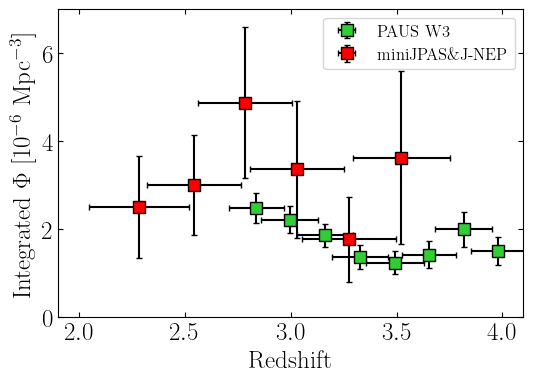

In [13]:
nb_list = [[0, 2], [2, 4], [4, 6], [6, 8],
           [8, 10], [10, 12], [12, 14], [14, 16]]
Lmin, Lmax = 43.6, 44.75
LF_bins = LyaLF['LF_bins']
bin_width = LF_bins[1] - LF_bins[0]
mask = (LF_bins < Lmax) & (LF_bins > Lmin)
mask_Lx = (np.log10(Lx) < Lmax) & (np.log10(Lx) > Lmin)

LF_err_list = np.array(
    [np.array(lf_err).sum(axis=0) * 0.5 for lf_err in LFs_err_mult_list])

LF_int_list = [(lf * bin_width)[mask].sum() for lf in LFs_mult_list]
LF_int_err_list = [((lf_err * bin_width)**2)[mask].sum() ** 0.5 for lf_err in LF_err_list]

z_list = []
for [nb1, nb2] in nb_list:
    z_min = (w_central[nb1] - fwhm_Arr[nb1] * 0.5) / w_lya - 1
    z_max = (w_central[nb2] + fwhm_Arr[nb2] * 0.5) / w_lya - 1
    z_list.append([z_min, z_max])

z_central_list = [(zmax + zmin) * 0.5 for [zmin, zmax] in z_list]

# # Power-law integral:
# pl_int = (Phi_fit_50[mask_Lx] * (np.log10(Lx[1]) - np.log10(Lx[0]))).sum()

fig, ax = plt.subplots(figsize=(6, 4))

# ax.axhline(pl_int * 1e6, ls='--', c='r', lw=3,
#            label='LF power-law fit')
ax.errorbar(z_central_list, np.array(LF_int_list) * 1e6,
            yerr=np.array(LF_int_err_list) * 1e6,
            xerr=[(zmax - zmin) * 0.5 for [zmin, zmax] in z_list],
            fmt='s', ms=8, capsize=2,
            ecolor='k', mfc='limegreen', mec='k',
            label=r'PAUS W3')

# Load miniJPAS data
z_central_list = np.load('/home/alberto/cosmos/LAEs/npy/z_central_list.npy')
LF_int = np.load('/home/alberto/cosmos/LAEs/npy/LF_int_list.npy')
LF_int_yerr = np.load('/home/alberto/cosmos/LAEs/npy/LF_int_yerr_list.npy')
LF_int_xerr = np.load('/home/alberto/cosmos/LAEs/npy/LF_int_xerr_list.npy')
ax.errorbar(z_central_list, LF_int * 1e6,
            yerr=LF_int_yerr * 1e6,
            xerr=LF_int_xerr,
            fmt='s', ms=8, capsize=2,
            ecolor='k', mfc='r', mec='k',
            label=r'miniJPAS\&J-NEP')



ax.legend(fontsize=12)

ax.tick_params(labelsize=18, direction='in', which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set(ylim=(0, 7), xlim=(1.9, 4.1))
ax.set_ylabel('Integrated $\Phi$ [10$^{-6}$ Mpc$^{-3}$]', fontsize=18)
ax.set_xlabel('Redshift', fontsize=18)
# ax.set_yscale('log')

# fig.savefig('figures/Integrated_LF.pdf', pad_inches=0.1, bbox_inches='tight',
#             facecolor='w')
plt.show()

In [ ]:
from plot.puricomp1D import plot_puricomp1d

nb_list = [[0, 2], [2, 4], [4, 6], [6, 8],
           [8, 10], [10, 12], [12, 14], [14, 16]]
# nb_list = [[0, 2]]
r_min, r_max = 17, 24

fig, axs = plt.subplots(2, 1, figsize=(6, 6),
                        sharex=True)

puricomp1d_L_bins = np.linspace(42.5, 45.5, 15)
puricomp1d_L_bins_c = bin_centers(puricomp1d_L_bins)

for jj, [nb_min, nb_max] in enumerate(nb_list):
    print(f'nb{nb_min}-{nb_max}')
    puri1d, comp1d = plot_puricomp1d('W3', nb_min, nb_max,
                                     r_min, r_max,
                                     L_bins=puricomp1d_L_bins)

    color = f'C{jj}'
    axs[0].plot(puricomp1d_L_bins_c, puri1d,
                label=f'NB: {nb_min}-{nb_max}',
                c=color)
    axs[1].plot(puricomp1d_L_bins_c, comp1d,
                c=color)

axs[0].set_ylabel('Purity')
axs[1].set_ylabel('Completeness')

for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('log L_Lya')

axs[0].legend(fontsize=10)

plt.show()

In [ ]:
import pickle

field_name = 'W3'
savedir = '/home/alberto/almacen/PAUS_data/LF_corrections'

nb_min, nb_max = 6, 8

with open(f'{savedir}/mock_dict_{field_name}_nb{nb_min}-{nb_max}.pkl', 'rb') as f:
    mock_dict = pickle.load(f)

area_dict = {
    'SFG': 400,
    'QSO_cont': 200,
    'QSO_LAEs_loL': 400,
    # 'QSO_LAEs_hiL': 4000,
    'GAL': 59.97
}

color_dict = {
    'SFG': 'C1',
    'QSO_cont': 'dimgray',
    'QSO_LAEs_loL': 'C0',
    'QSO_LAEs_hiL': 'C0',
    'GAL': 'C2'
}

fig, ax = plt.subplots(figsize=(6, 4))

L_bins = np.linspace(43, 46, 30)

for mock_name, area in area_dict.items():
    to_hist = mock_dict[mock_name]['L_lya']
    ax.hist(to_hist, L_bins,
            histtype='step', lw=2,
            weights=np.ones_like(to_hist) / area_dict[mock_name],
            color=color_dict[mock_name])

plt.show()

In [ ]:
mock = mock_dict['SFG']
nice_lya = mock['nice_lya_0']
nice_z = np.abs(z_NB(mock['lya_NB']) - mock['zspec']) < 0.11

sum(nice_z) / 400

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(mock_dict['QSO_LAEs_loL']['L_lya_spec'],
           mock_dict['QSO_LAEs_loL']['L_lya'])

xx = [-100, 100]
ax.plot(xx, xx, ls='--', c='r')

ax.set_ylim(43, 46)
ax.set_xlim(43, 46)

plt.show()